In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from tqdm import tqdm

In [14]:
class LargeGridWorld:
    def __init__(self, size=100, obstacle_density=0.2):
        self.size = size
        self.grid = np.zeros((size, size))
        self.start = (0, 0)
        self.goal = (size-1, size-1)
        mask = np.random.random((size, size)) < obstacle_density
        mask[0, 0] = False  
        mask[-1, -1] = False  
        self.grid[mask] = 1
        self.valid_actions = {}
        
    def get_actions(self, state):
        if state not in self.valid_actions:
            actions = []
            x, y = state
            for dx, dy in [(0,1), (1,0), (0,-1), (-1,0)]:
                new_x, new_y = x + dx, y + dy
                if (0 <= new_x < self.size and 
                    0 <= new_y < self.size and 
                    self.grid[new_x, new_y] != 1):
                    actions.append((dx, dy))
            self.valid_actions[state] = actions
        return self.valid_actions[state]
    
    def step(self, state, action):
        x, y = state
        dx, dy = action
        new_state = (x + dx, y + dy)
        
        if new_state == self.goal:
            return new_state, 100, True
        
        return new_state, -1, False

In [15]:
class FastQLearning:
    def __init__(self, env, learning_rate=0.1, gamma=0.95, epsilon=0.1):
        self.env = env
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: defaultdict(float))
        
    def get_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.env.get_actions(state))
        actions = self.env.get_actions(state)
        return max(actions, key=lambda a: self.Q[state][a])
    
    def train(self, episodes=1000):
        rewards_history = []
        best_episode_reward = float('-inf')
        best_path = []
        
        for episode in tqdm(range(episodes)):
            state = self.env.start
            current_path = [state]
            total_reward = 0
            steps = 0
            max_steps = self.env.size * 2  # Limit steps per episode
            
            while steps < max_steps:
                action = self.get_action(state)
                next_state, reward, done = self.env.step(state, action)
                current_path.append(next_state)
                
                # Q-learning update
                next_actions = self.env.get_actions(next_state)
                next_max = max([self.Q[next_state][a] for a in next_actions]) if next_actions else 0
                
                self.Q[state][action] = self.Q[state][action] + self.lr * (
                    reward + self.gamma * next_max - self.Q[state][action]
                )
                
                total_reward += reward
                state = next_state
                steps += 1
                
                if done:
                    if total_reward > best_episode_reward:
                        best_episode_reward = total_reward
                        best_path = current_path
                    break
            
            rewards_history.append(total_reward)
            self.epsilon = max(0.01, self.epsilon * 0.995)
            
        return rewards_history, best_path

In [16]:
def visualize_grid_and_path(env, path):
    plt.figure(figsize=(10, 10))
    plt.imshow(env.grid, cmap='binary')
    
    if path:
        path = np.array(path)
        plt.plot(path[:, 1], path[:, 0], 'r-', linewidth=2, label='Best Path')
        plt.plot(path[0, 1], path[0, 0], 'go', label='Start')
        plt.plot(path[-1, 1], path[-1, 0], 'ro', label='Goal')
    
    plt.title('100x100 Grid with Best Path')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_rewards(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title('Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()

Training Q-Learning agent...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 469.29it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


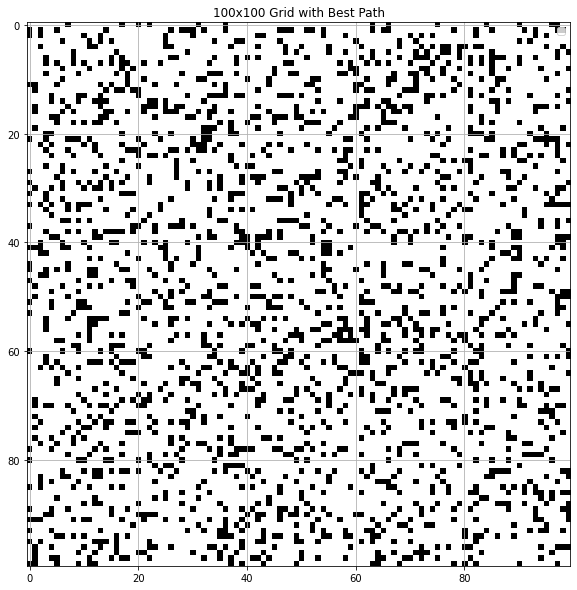

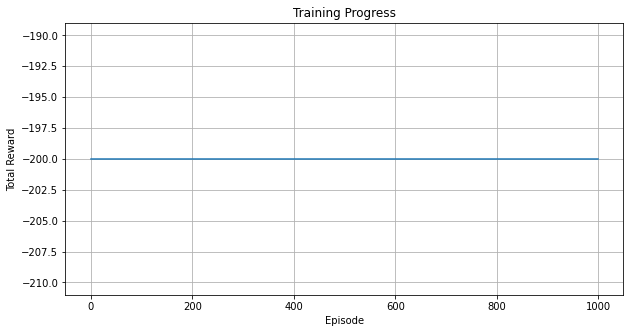

Training completed!
Best path length: 0
Final average reward (last 100 episodes): -200.00


In [8]:
def main():
    env = LargeGridWorld(size=100, obstacle_density=0.2)
    agent = FastQLearning(env, learning_rate=0.1, gamma=0.95, epsilon=0.1)
    
    print("Training Q-Learning agent...")
    rewards, best_path = agent.train(episodes=1000)
    
    visualize_grid_and_path(env, best_path)
    plot_rewards(rewards)
    
    print(f"Training completed!")
    print(f"Best path length: {len(best_path)}")
    print(f"Final average reward (last 100 episodes): {np.mean(rewards[-100:]):.2f}")

if __name__ == "__main__":
    main()

In [ ]:
class SarsaAgent(QLearningAgent):
    def update_q(self, state, action, reward, next_state, done):
        next_action = self.get_action(next_state) if not done else action
        self.Q[state][action] += self.lr * (reward + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])

In [ ]:
class DoubleQLearningAgent(QLearningAgent):
    def __init__(self, env, learning_rate=0.1, gamma=0.95, epsilon=0.1):
        super().__init__(env, learning_rate, gamma, epsilon)
        self.Q1 = defaultdict(lambda: defaultdict(float))
        self.Q2 = defaultdict(lambda: defaultdict(float))

    def get_action(self, state):
        actions = self.env.get_actions(state)
        return max(actions, key=lambda a: self.Q1[state][a] + self.Q2[state][a])

    def update_q(self, state, action, reward, next_state, done):
        if random.random() < 0.5:
            max_next_action = max(self.env.get_actions(next_state), key=lambda a: self.Q1[next_state][a], default=action)
            self.Q1[state][action] += self.lr * (reward + self.gamma * self.Q2[next_state][max_next_action] - self.Q1[state][action])
        else:
            max_next_action = max(self.env.get_actions(next_state), key=lambda a: self.Q2[next_state][a], default=action)
            self.Q2[state][action] += self.lr * (reward + self.gamma * self.Q1[next_state][max_next_action] - self.Q2[state][action])

In [ ]:
def plot_rewards(rewards_dict):
    plt.figure(figsize=(12, 6))
    for label, rewards in rewards_dict.items():
        plt.plot(rewards, label=label)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.title('Performance Comparison')
    plt.grid(True)
    plt.show()

In [ ]:
def train_agent(agent, episodes=1000):
    rewards_history = []
    for episode in tqdm(range(episodes)):
        state = agent.env.start
        total_reward = 0
        steps = 0
        max_steps = agent.env.size * 2
        
        while steps < max_steps:
            action = agent.get_action(state)
            next_state, reward, done = agent.env.step(state, action)
            agent.update_q(state, action, reward, next_state, done)
            total_reward += reward
            state = next_state
            steps += 1
            if done:
                break
        
        rewards_history.append(total_reward)
        agent.epsilon = max(0.01, agent.epsilon * 0.995)
        
    return rewards_history

In [ ]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, gamma=0.95, epsilon=0.1):
        self.env = env
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: defaultdict(float))

    def get_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.env.get_actions(state))
        actions = self.env.get_actions(state)
        return max(actions, key=lambda a: self.Q[state][a])

    def update_q(self, state, action, reward, next_state, done):
        next_actions = self.env.get_actions(next_state)
        next_max = max([self.Q[next_state][a] for a in next_actions]) if next_actions else 0
        self.Q[state][action] += self.lr * (reward + self.gamma * next_max - self.Q[state][action])

In [ ]:
class GridWorld:
    def __init__(self, width, height, start, goal, obstacles):
        self.width = width
        self.height = height
        self.start = start
        self.goal = goal
        self.obstacles = obstacles
        self.state = start

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        x, y = self.state
        if action == 0:  
            next_state = (x, max(y - 1, 0))
        elif action == 1: 
            next_state = (min(x + 1, self.width - 1), y)
        elif action == 2:  
            next_state = (x, min(y + 1, self.height - 1))
        elif action == 3:  
            next_state = (max(x - 1, 0), y)

        if next_state in self.obstacles:
            next_state = self.state

        reward = 1 if next_state == self.goal else -1
        done = next_state == self.goal
        self.state = next_state
        return next_state, reward, done

In [ ]:
class SARSAAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}
        for x in range(env.width):
            for y in range(env.height):
                self.q_table[(x, y)] = [0] * 4

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, 3)  
        else:
            return np.argmax(self.q_table[state])  

    def learn(self, state, action, reward, next_state, next_action):
        q_value = self.q_table[state][action]
        next_q_value = self.q_table[next_state][next_action]
        self.q_table[state][action] = q_value + self.alpha * (reward + self.gamma * next_q_value - q_value)

    def train(self, episodes):
        for episode in range(episodes):
            state = self.env.reset()
            action = self.choose_action(state)
            done = False
            total_reward = 0

            while not done:
                next_state, reward, done = self.env.step(action)
                next_action = self.choose_action(next_state)
                self.learn(state, action, reward, next_state, next_action)
                state, action = next_state, next_action
                total_reward += reward

            print(f"Episode {episode + 1}, Total Reward: {total_reward}")

In [11]:
width, height = 5, 5
start, goal = (0, 0), (4, 4)
obstacles = [(1, 1), (2, 2), (3, 3)]

env = GridWorld(width, height, start, goal, obstacles)
agent = SARSAAgent(env, alpha=0.1, gamma=0.99, epsilon=0.1)

agent.train(episodes=500)

for state, actions in agent.q_table.items():
    print(f"State {state}: Q-Values {actions}")

Episode 1, Total Reward: -104
Episode 2, Total Reward: -34
Episode 3, Total Reward: -107
Episode 4, Total Reward: -13
Episode 5, Total Reward: -45
Episode 6, Total Reward: -54
Episode 7, Total Reward: -80
Episode 8, Total Reward: -67
Episode 9, Total Reward: -10
Episode 10, Total Reward: -99
Episode 11, Total Reward: -16
Episode 12, Total Reward: -27
Episode 13, Total Reward: -21
Episode 14, Total Reward: -49
Episode 15, Total Reward: -31
Episode 16, Total Reward: -21
Episode 17, Total Reward: -17
Episode 18, Total Reward: -28
Episode 19, Total Reward: -36
Episode 20, Total Reward: -27
Episode 21, Total Reward: -18
Episode 22, Total Reward: -41
Episode 23, Total Reward: -16
Episode 24, Total Reward: -18
Episode 25, Total Reward: -31
Episode 26, Total Reward: -22
Episode 27, Total Reward: -10
Episode 28, Total Reward: -17
Episode 29, Total Reward: -11
Episode 30, Total Reward: -14
Episode 31, Total Reward: -39
Episode 32, Total Reward: -25
Episode 33, Total Reward: -25
Episode 34, Total

In [10]:
def value_iteration(env, gamma=0.9, theta=1e-5):
    V = np.zeros((env.size, env.size))
    policy = {}
    while True:
        delta = 0
        for x in range(env.size):
            for y in range(env.size):
                state = (x, y)
                if state == env.goal:
                    continue
                v = V[x, y]
                action_values = []
                for action in env.get_actions(state):
                    next_state, reward, _ = env.step(state, action)
                    nx, ny = next_state
                    action_values.append(reward + gamma * V[nx, ny])
                V[x, y] = max(action_values) if action_values else v
                delta = max(delta, abs(v - V[x, y]))
                policy[state] = action_values.index(max(action_values)) if action_values else None
        if delta < theta:
            break
    return policy, V

class QLearningAgent:
    def __init__(self, env, lr=0.1, gamma=0.95, epsilon=0.1):
        self.env = env
        self.Q = defaultdict(lambda: defaultdict(float))
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.env.get_actions(state))
        actions = self.env.get_actions(state)
        return max(actions, key=lambda a: self.Q[state][a])

    def train(self, episodes=1000):
        for _ in tqdm(range(episodes)):
            state = self.env.start
            while state != self.env.goal:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(state, action)
                best_next_action = max(self.env.get_actions(next_state), key=lambda a: self.Q[next_state][a], default=None)
                td_target = reward + self.gamma * self.Q[next_state][best_next_action]
                self.Q[state][action] += self.lr * (td_target - self.Q[state][action])
                state = next_state
                if done:
                    break

env = LargeGridWorld(size=100, obstacle_density=0.2, start=(0, 0), goal=(99, 99))

print("Running Value Iteration...")
dp_policy, dp_value = value_iteration(env)

print("Running Q-learning...")
q_agent = QLearningAgent(env)
q_agent.train(episodes=1000)

print("DP Policy Value Sum:", np.sum(dp_value))
print("Q-learning Q-Value Sum:", sum(sum(actions.values()) for actions in q_agent.Q.values()))


Running Value Iteration...
Running Q-learning...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:09<00:00,  5.27it/s]

DP Policy Value Sum: -91631.81414000012
Q-learning Q-Value Sum: -385347.65723740065
